In [65]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def f(x):
    return x**2 + x + 5

In [67]:
f(3.0)

17.0

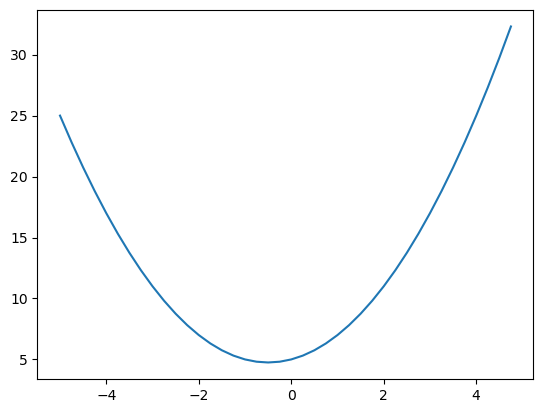

In [68]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [69]:
h = 0.000000000001
x = -2/3
(f(x+h) - f(x))/h

-0.33306690738754696

In [142]:
# we find derivatives of functions with multiple inputs

a = 2.0
b = -3.0
c = 10.0

# find derivative with respect to a, b or c
d1 = a*b + c

# change to find derivative wrt each input
b += h
d2 = a*b + c

print(d1)
print(d2)
print("slope: " + str((d2-d1)/h))




4.0
4.000000000002
slope: 2.000177801164682


In [179]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self._backward = lambda: None # to chain derivs 
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self,other):
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out
    
    def backward(self):

        # topological sort 
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [180]:
a = Value(2.0)
b = Value(4.0)

a.__truediv__(b)

a - b

Value(data=-2.0)

In [144]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

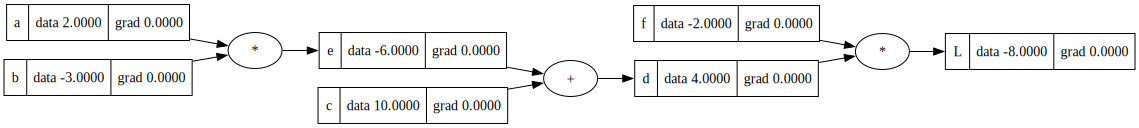

In [117]:
draw_dot(L)

In [181]:
# neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

o.backward()

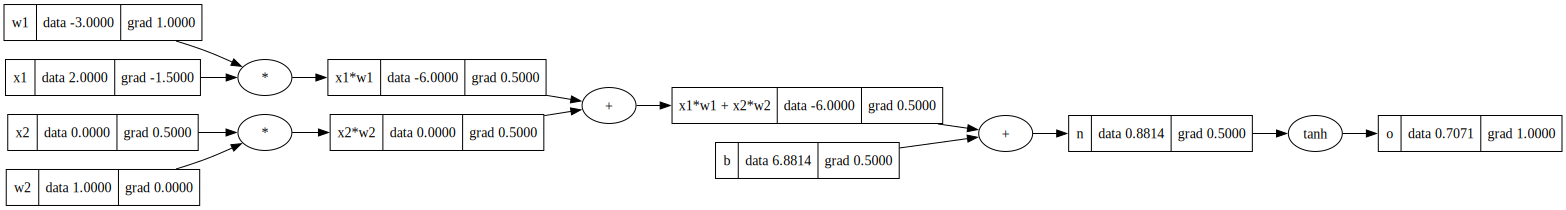

In [182]:
draw_dot(o)

In [189]:
# neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# full implementation of tanh

e = (2*n).exp()
o = (e - 1)/(e + 1)

o.label='o'
o.backward()

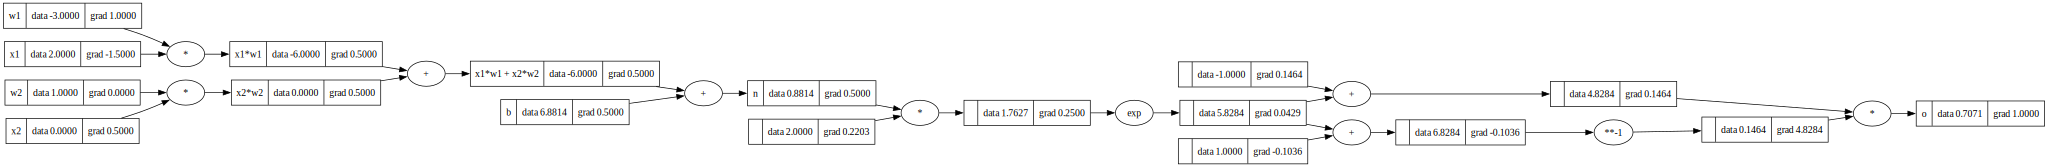

In [190]:
draw_dot(o)

In [192]:
import torch

In [288]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [355]:
import random

class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]

class Layer:

     def __init__(self, nin, nout):
         self.neurons = [Neuron(nin) for _ in range(nout)]

     def __call__(self,x):
         outs = [n(x) for n in self.neurons]
         return outs[0] if len(outs) == 1 else outs
         
     def parameters(self):
         return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]




In [404]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.6716293546626856)

In [338]:
n.parameters()

[Value(data=0.8034517638693293),
 Value(data=-0.37502052795407104),
 Value(data=0.9239473530768922),
 Value(data=-0.8360624464548523),
 Value(data=-0.7357608445707979),
 Value(data=-0.11989031144361917),
 Value(data=-0.5888089230863933),
 Value(data=-0.6008737532846866),
 Value(data=0.15736901166394324),
 Value(data=0.6102442057614414),
 Value(data=0.23239772376345824),
 Value(data=0.17999826578449385),
 Value(data=-0.28942524809681514),
 Value(data=0.25538048884870257),
 Value(data=-0.676152582243041),
 Value(data=-0.10699794488609782),
 Value(data=-0.5718284025038074),
 Value(data=0.4943514267737774),
 Value(data=0.5932910549363359),
 Value(data=-0.6838418464214588),
 Value(data=-0.43176065016627607),
 Value(data=-0.8717695622600952),
 Value(data=0.26503309927255736),
 Value(data=0.6477444010353317),
 Value(data=0.42000064034855655),
 Value(data=0.022014379788849903),
 Value(data=-0.12823350163389913),
 Value(data=-0.9407340597972733),
 Value(data=-0.9294711084631586),
 Value(data=0.

In [402]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [429]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
    
    # backward pass 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 0.007510224940253476
1 0.007491583247858015
2 0.0074730302457615885
3 0.00745456531341543
4 0.0074361878359868235
5 0.0074178972042940015
6 0.007399692814741702
7 0.007381574069257869
8 0.007363540375230851
9 0.007345591145447963
10 0.007327725798034305
11 0.007309943756392779
12 0.007292244449144919
13 0.007274627310072151
14 0.0072570917780583
15 0.007239637297032576
16 0.0072222633159133905
17 0.00720496928855289
18 0.00718775467368225
19 0.007170618934857759


In [430]:
ypred

[Value(data=0.9745143106026797),
 Value(data=-0.9517750942407985),
 Value(data=-0.9579953314689331),
 Value(data=0.9506941701528875)]